In [1]:
from math import sin, cos, sqrt, atan2, radians, floor
import glob
import re

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid, GridSearchCV, LeaveOneOut
from sklearn.preprocessing import FunctionTransformer, Imputer

import matplotlib.pyplot as plt
%matplotlib inline

### Download list of GSOP stations

In [2]:
!wget ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.csv --directory-prefix data

--2018-07-16 12:56:32--  ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.csv
           => ‘data/isd-history.csv’
Resolving ftp.ncdc.noaa.gov (ftp.ncdc.noaa.gov)... 205.167.25.101, 2610:20:8040:2::101
Connecting to ftp.ncdc.noaa.gov (ftp.ncdc.noaa.gov)|205.167.25.101|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/data/noaa ... done.
==> SIZE isd-history.csv ... 2905262
==> PASV ... done.    ==> RETR isd-history.csv ... done.
Length: 2905262 (2.8M) (unauthoritative)

isd-history.csv     100%[===================>]   2.77M  3.02MB/s    in 0.9s    

2018-07-16 12:56:34 (3.02 MB/s) - ‘data/isd-history.csv’ saved [2905262]



In [3]:
!wc -l data/isd-history.csv

29630 data/isd-history.csv


In [4]:
# load data, filter to US and Canada and stations with locations
stations = pd.read_csv('data/isd-history.csv')
stations = stations.loc[stations.CTRY.isin(['US', 'CA']), :]
stations = stations.loc[~((stations.LAT.fillna(0) == 0) & (stations.LON.fillna(0) == 0)), :]
stations.head(5)

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
9656,423630,99999,MISSISSIPPI CANYON OIL PLATFORM,US,LA,NaN,28.160,-89.220,37.0,20130206,20160618
13052,619760,99999,SERGE-FROLOW (ILE TROMELIN),US,NaN,NaN,-15.883,54.517,13.0,19730101,20180713
13086,621010,99999,MOORED BUOY,US,NaN,NaN,50.600,-2.933,-999.0,20080721,20080721
13088,621110,99999,MOORED BUOY,US,NaN,NaN,58.900,-0.200,-999.0,20041118,20091201
13089,621130,99999,MOORED BUOY,US,NaN,NaN,58.400,0.300,-999.0,20040726,20040726


### Identify stations closest to MOBE

In [5]:
# location of mobe
mobe_lat, mobe_lon = (45.0150428, -93.456006)

# haversine distance between two points
def haversine(lat1, lon1, lat2=mobe_lat, lon2=mobe_lon):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [6]:
# distance of each station from MOBE
stations['distance'] = stations.apply(lambda row: haversine(row['LAT'], row['LON']), axis=1)
stations.sort_values(by=['distance'], ascending=True, inplace=True)
stations = stations.loc[(stations.BEGIN <= 19980000) & (stations.END >= 20170000), :]
stations.head(3)

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END,distance
20855,726580,14922,MINNEAPOLIS-ST PAUL INTERNATIONAL AP,US,MN,KMSP,44.883,-93.229,265.8,19450101,20180714,23.131246
20858,726584,14927,ST PAUL DWTWN HOLMAN FD AP,US,MN,KSTP,44.932,-93.056,213.4,19831103,20180714,32.802851
20806,726550,14926,ST CLOUD REGIONAL AIRPORT,US,MN,KSTC,45.543,-94.051,307.5,19730101,20180714,74.947609


### Download station/year files for closest stations

In [7]:
top3 = stations.apply(lambda row: '{}-{}'.format(row['USAF'], row['WBAN']), axis=1).head(3).tolist()
top3 = ' '.join(top3)

In [8]:
%%bash -s "{top3}"
for prefix in $@; do
    for year in {1998..2017}; do
        wget ftp://ftp.ncdc.noaa.gov/pub/data/gsod/$year/$prefix-$year.op.gz --quiet --directory-prefix data
        gunzip data/$prefix-$year.op.gz
    done
done

gzip: data/726584-14927-2000.op.gz: No such file or directory
gzip: data/726584-14927-2001.op.gz: No such file or directory
gzip: data/726584-14927-2002.op.gz: No such file or directory
gzip: data/726584-14927-2003.op.gz: No such file or directory


In [9]:
# load data
list_ = []
for file_ in glob.glob("data/*.op"):
    df = pd.read_fwf(file_)
    list_.append(df)
df = pd.concat(list_)

In [10]:
# cleanup
df = df.loc[:, ~df.columns.str.startswith('Unnamed')]
df['FRSHTT'] = df.FRSHTT.apply(lambda x: str(x).zfill(6))
df.head(5)

,STN---,WBAN,YEARMODA,TEMP,DEWP,SLP,STP,VISIB,WDSP,MXSPD,GUST,MAX,MIN,PRCP,SNDP,FRSHTT
0,726550,14926,19980101,22.3,17.7,1008.8,969.1,9.4,8.3,14.0,999.9,39.0*,8.1*,0.00G,999.9,100000
1,726550,14926,19980102,30.9,27.7,1005.0,966.3,9.2,5.8,11.1,999.9,39.0*,21.9*,0.00D,999.9,100000
2,726550,14926,19980103,16.4,11.3,1015.6,975.8,8.7,10.9,21.0,22.0,32.0*,7.0*,0.00C,999.9,100000
3,726550,14926,19980104,11.5,4.2,1027.2,986.3,9.9,5.9,10.1,999.9,24.1*,3.9*,0.00C,999.9,000000
4,726550,14926,19980105,24.3,22.0,1019.2,979.6,7.9,6.1,8.0,999.9,30.2*,21.0*,0.00H,999.9,111000


### Calculate total snowfall and average temperature by year

In [11]:
# calculate snowfall and average temperature by year
has_snow = df.FRSHTT.apply(lambda x: int(x[2])) > 0
has_prcp = ~df.PRCP.str.startswith('99.9')
is_winter = df.YEARMODA.apply(lambda x: x % 10000).between(101, 331) | \
            df.YEARMODA.apply(lambda x: x % 10000).between(1001, 1231)

df2 = df.copy()
df2.loc[~is_winter, ['TEMP']] = np.nan
df2 = df2.loc[has_snow & has_prcp, :].copy()
df2['PRCP'] = df2.PRCP.apply(lambda x: float(x[:-1]))
    
agg = {'PRCP': 'sum', 'TEMP': 'mean'}
df2 = df2.groupby(by=['YEARMODA'], as_index=False).agg(agg)

df2['YEAR'] = df2.YEARMODA.apply(lambda x: floor(x/10000))
df2 = df2.groupby(by=['YEAR'], as_index=False).agg(agg)
df2['PRCP'] = df2.PRCP * 13

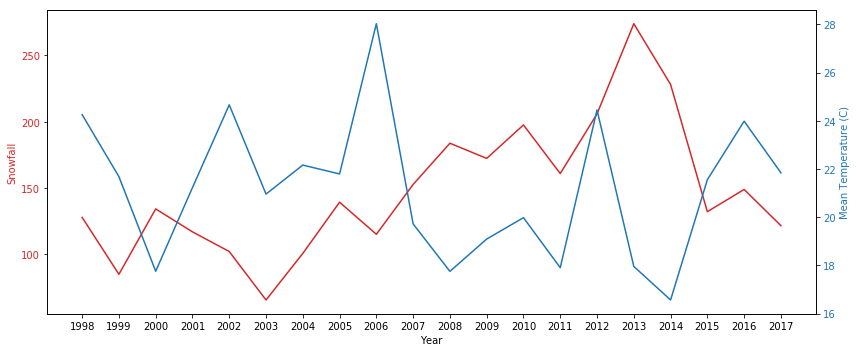

In [12]:
# plot
x = df2.YEAR
y1 = df2.PRCP
y2 = df2.TEMP

fig, ax1 = plt.subplots(figsize=(12, 5))

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Snowfall', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Mean Temperature (C)', color=color)
ax2.plot(x, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.xticks(x)
plt.show()

### Temperature prediction

In [13]:
# simply model using trailing n-year temperature
def add_rolling(df, window):
    df2 = df.copy()
    df2['TEMP_LAG1'] = df2.TEMP.shift(1)
    df2['TEMP_ROLLING'] = df2.rolling(window=window, min_periods=1).mean()['TEMP_LAG1']
    return df2[['TEMP_ROLLING']]

model = Pipeline(steps=[
    ('ft', FunctionTransformer(func=add_rolling, validate=False, kw_args={'window': 3})),
    ('im', Imputer()),
    ('lr', LinearRegression())
])

param_grid = {'ft__kw_args': [{'window': i} for i in range(1, 6)]}

loo = LeaveOneOut()
tuner = GridSearchCV(model, param_grid, scoring="neg_mean_absolute_error", cv=loo, refit=False)
tuner.fit(df2, df2.TEMP)

cv_results = np.array([v for k,v in tuner.cv_results_.items() if re.match("split[0-9]*_train_score", k)]).mean(axis=0)
best_params_idx = np.argmax(cv_results)
best_params = ParameterGrid(param_grid)[best_params_idx]

print('Best params: %s' % (str(best_params)))

Best params: {'ft__kw_args': {'window': 5}}


In [14]:
# generate prediction
window = best_params['ft__kw_args']['window']
model.set_params(**best_params)
model.fit(df2, df2.TEMP)
temp_pred = model.predict(df2.tail(window + 1))[-1]
temp_pred

21.263166018459522

### Snow prediction based on temperature prediction

In [15]:
# simple model for snowfall as a function of temperature
# negative coefficient --> warmer = less snow
model2 = LinearRegression()
model2.fit(df2.TEMP.values.reshape(-1, 1), df2.PRCP)
model2.coef_

array([-8.30755676])

In [16]:
# generate prediction
snow_pred = model2.predict(np.array(temp_pred).reshape(-1, 1))[0]
snow_pred

147.49726390163684

In [17]:
np.mean(np.where(snow_pred > df2.PRCP, 1, 0))

0.55